In [1]:
import numpy as np 
import pandas as pd 
import os
from pathlib import Path
import timm
import random
from typing import List
import glob

from fastai.basics           import *
from fastai.medical.imaging  import *

from dataclasses import dataclass, field, asdict

import logging
from transformers import Trainer, TrainingArguments

import albumentations as A

import sklearn
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.nn.functional as F


/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# config

In [2]:
DEBUG = False

@dataclass
class DatasetConfig:
    path: Path = Path('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/')
    label_columns = [
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1']
    label_map = {
        'Normal/Mild': 0,
        'Moderate': 1,
        'Severe': 2,
        -100: -100 # for missing values
    }
    use_n_images: int = 18  # select images

@dataclass
class ModelConfig:
    name: str = 'efficientnet_b3.ra2_in1k' # resnet or efficientnet
    train_backbone: bool = False # fine-tuned?
    use_weights: bool = True  # use weighted loss?

@dataclass
class Config:
    dataset: DatasetConfig = field(default_factory=DatasetConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    seed: int = 42
    n_folds: int = 5
        
args = TrainingArguments(
    output_dir='/kaggle/working/',
    do_eval=True,
    report_to='none',
    remove_unused_columns=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
#     torch_compile=True,
    num_train_epochs=5,
    warmup_ratio=0.05,
    logging_strategy='steps',
    logging_steps=10,
   # save_strategy='epoch',
    save_strategy='steps',
    save_steps=2,
    load_best_model_at_end=True,
    save_total_limit=2,
    save_safetensors=False,
#     fp16=True,
    metric_for_best_model='log_loss',
#    eval_strategy='epoch',
    eval_strategy='steps',          # 设置为 'steps'，每隔一定batch评估一次
    eval_steps=2,                  # 每10个 batch 评估一次
    dataloader_num_workers=4,
    label_names=['labels'],
#     optim="adafactor",
)

config = Config()

wandb_config = {
    'config': asdict(config),
    'training_args': asdict(args)
}

import datetime
NAME = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# build model ResNet

In [3]:
config.model.name = 'resnet50'
backbone = timm.create_model(config.model.name, pretrained=True)

if not config.model.train_backbone:
    for param in backbone.parameters():
        param.require_grad = False

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(backbone)
transforms = timm.data.create_transform(**data_config, is_training=False)

transforms.transforms[-1].mean = transforms.transforms[-1].mean.mean()
transforms.transforms[-1].std = transforms.transforms[-1].std.mean()

IMG_WIDTH, IMG_HEIGHT = transforms.transforms[1].size

class Model1_ResNet(nn.Module):
    def __init__(self, backbone):
        super(Model1_ResNet, self).__init__()
        self.name = "ResNet"
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Linear(self.backbone.num_features, len(config.dataset.label_columns)*3)

    def forward(self, **kwargs):
        batch = dict(**kwargs)
        # x: (B, N_IMAGES, C, H, W)
        # 
        features_output = []
        for series_description in ['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']:
            if not series_description in batch:
                # not used, we just forward zeros through backbone
                features_output.append(None)
            else:
                images = batch[series_description]
                # b 15 1 h w
                B, N_IMAGES, C, H, W = images.shape
                if config.model.train_backbone:
                    features = self.backbone.forward_features(images.view(B * N_IMAGES, C, H, W))
                else:
                    with torch.no_grad():
                        features = self.backbone.forward_features(images.view(B * N_IMAGES, C, H, W))
                features = self.pool(features).squeeze(-1).squeeze(-1)
                features = self.head(features).view(B, N_IMAGES, -1)
                # features: (B, N_IMAGES, label_columns * 3)
                features_output.append(features)
        for i in range(len(features_output)):
            if features_output[i] is None:
                features_output[i] = torch.zeros((B, N_IMAGES, self.backbone.num_features), device=images.device)
        features_output = torch.cat(features_output, 1)
        output = features_output.mean(1)
        output = output.view(-1, 10, 3)

        loss = None
        if 'labels' in batch:
            if config.model.use_weights:
                loss_fn = torch.nn.CrossEntropyLoss(torch.tensor([1., 2., 4.], device=output.device))
            else:
                loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(output.view(-1, 3), batch['labels'].view(-1, ))

        return loss, output

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

# build model efficient+lstm

@todo

In [4]:
config.model.name = 'efficientnet_b3.ra2_in1k'
backbone = timm.create_model(config.model.name, pretrained=True)

if not config.model.train_backbone:
    for param in backbone.parameters():
        param.require_grad = False

data_config = timm.data.resolve_model_data_config(backbone)
transforms = timm.data.create_transform(**data_config, is_training=False)

transforms.transforms[-1].mean = transforms.transforms[-1].mean.mean()
transforms.transforms[-1].std = transforms.transforms[-1].std.mean()

IMG_WIDTH, IMG_HEIGHT = transforms.transforms[1].size

class Model2_LSTM(nn.Module):
    def __init__(self, backbone):
        super(Model2_LSTM, self).__init__()
        self.name = "LSTM"
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(input_size=backbone.num_features * 3, hidden_size=256, num_layers=1, batch_first=True, bidirectional=True)
        self.head = nn.Linear(512, len(config.dataset.label_columns) * 3)
        
    def forward(self, **kwargs):
        batch = dict(**kwargs)
        features_output = []

        for series_description in ['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']:
            if series_description not in batch:
                features_output.append(None)
            else:
                gray_images = batch[series_description].to('cuda')
                images = gray_images.repeat(1, 1, 3, 1, 1)
                
                B, N_IMAGES, C, H, W = images.shape
                mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1 ,3, 1, 1).to('cuda')
                std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3, 1, 1).to('cuda')
                images = (images - mean) / std

                if config.model.train_backbone:
                    features = self.backbone.forward_features(images.view(B * N_IMAGES, C, H, W))
                else:
                    with torch.no_grad():
                        features = self.backbone.forward_features(images.view(B * N_IMAGES, C, H, W))

                features = self.pool(features).squeeze(-1).squeeze(-1).view(B, N_IMAGES, -1)

                # 如果该序列图像数量少于 15 张，进行填充
                if N_IMAGES < 15:
                    padding = torch.zeros((B, 15 - N_IMAGES, self.backbone.num_features), device=features.device)
                    features = torch.cat([features, padding], dim=1)

                features_output.append(features)

        # 将特征拼接在最后一个维度
        features_output = torch.cat(features_output, -1)

        lstm_out, _ = self.lstm(features_output)

        lstm_out = lstm_out.mean(1)
        output = self.head(lstm_out).view(-1, 10, 3)

        loss = None
        if 'labels' in batch:
            if config.model.use_weights:
                weight = torch.tensor([1., 2., 4.], device=output.device)
                loss_fn = torch.nn.CrossEntropyLoss(weight=weight)
            else:
                loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(output.view(-1, 3), batch['labels'].view(-1, ))

        return loss, output

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

# build model ResNet50 + Transformer

@todo

In [5]:
import torch
import torch.nn as nn

backbone = timm.create_model('resnet50', pretrained=True)
if not config.model.train_backbone:
    for param in backbone.parameters():
        param.require_grad = False

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(backbone)
transforms = timm.data.create_transform(**data_config, is_training=False)

transforms.transforms[-1].mean = transforms.transforms[-1].mean.mean()
transforms.transforms[-1].std = transforms.transforms[-1].std.mean()

IMG_WIDTH, IMG_HEIGHT = transforms.transforms[1].size

class Model3_ViT(nn.Module):
    def __init__(self, backbone = backbone,
                 input_dim=2048, num_tokens=40, num_classes=30, d_model=512, nhead=8, num_layers=2):
        super(Model3_ViT, self).__init__()
        self.name = "resNet50 + ViT"
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Linear(1024, len(config.dataset.label_columns)*3)
        
        
        # Linear layer to project input to the desired embedding dimension
        self.input_projection = nn.Linear(input_dim, d_model)
        # Positional encoding for the sequence length (num_tokens)
        self.positional_encoding = nn.Parameter(torch.randn(1, num_tokens, d_model))
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, **kwargs):
        batch = dict(**kwargs)
        # x: (B, N_IMAGES, C, H, W)
        features_output = []
        for series_description in ['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']:
            if not series_description in batch:
                # not used, we just forward zeros through backbone
                features_output.append(None)
            else:
                gray_images = batch[series_description].to('cuda')
                images = gray_images.repeat(1, 1, 3, 1, 1)
                
                # Normalize images
                mean = torch.tensor([0.485, 0.456, 0.406], device=images.device).view(1, 1, 3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225], device=images.device).view(1, 1, 3, 1, 1)
                images = (images - mean) / std
                
                B, N_IMAGES, C, H, W = images.shape
                if config.model.train_backbone:
                    features = self.backbone.forward_features(images.view(B * N_IMAGES, C, H, W))
                else:
                    with torch.no_grad():
                        features = self.backbone.forward_features(images.view(B * N_IMAGES, C, H, W))
                features = self.pool(features).squeeze(-1).squeeze(-1).view(B, N_IMAGES, -1)
                
                features_output.append(features)
        for i in range(len(features_output)):
            if features_output[i] is None:
                features_output[i] = torch.zeros((B, N_IMAGES, self.backbone.num_features), device=images.device)
        features_output = torch.cat(features_output, 1)
        
        
        # Project input to d_model dimension
        x = self.input_projection(features_output)  # Shape: (B, 40, d_model)
        # Add positional encoding
        x = x + self.positional_encoding  # Shape: (B, 40, d_model)
        # Permute to (seq_len, batch, embedding_dim) for transformer
        x = x.permute(1, 0, 2)  # Shape: (40, B, d_model)
        # Transformer Encoder
        x = self.transformer_encoder(x)  # Shape: (40, B, d_model)
        # Take the mean of the sequence dimension for classification
        x = x.mean(dim=0)  # Shape: (B, d_model
        # Classification head
        output = self.classifier(x)  # Shape: (B, num_classes)
        
#         output = self.classifier(features_output)
        output = output.view(-1, 10, 3)
            
        loss = None
        if 'labels' in batch:
            if config.model.use_weights:
                loss_fn = torch.nn.CrossEntropyLoss(torch.tensor([1., 2., 4.], device=output.device))
            else:
                loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(output.view(-1, 3), batch['labels'].view(-1, ).to("cuda"))
        
        return loss, output

# crop

In [6]:
from torchvision import transforms

model_path = "/kaggle/input/resnet3/pytorch/default/1/resnet18_1_Input3Channels.pt"
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as transforms

class Croper:
    def __init__(self, model_path):
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = "cpu"
        # Create ResNet18 model and set it to the device
        self.model = timm.create_model('resnet18', pretrained=True, num_classes=10)
        self.model.load_state_dict(torch.load(model_path))
        self.model = self.model.to(self.device)   
        self.model.eval()
    

    def crop_saggital(self, images, h, w):
        results = []
        for dicom_data in images:
            image = dicom_data.pixel_array.astype(np.float32) # H, W
            H, W = image.shape
            img_tensor = torch.tensor(image).unsqueeze(0)

            # Resize image to (1, 256, 256)
            image_pre = (image - np.min(image)) / (np.max(image) - np.min(image))
            image_pre = torch.tensor(image_pre).unsqueeze(0)
            image_pre = F.interpolate(image_pre.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)  # (1, 256, 256)

            # Change to (1, 3, 256, 256) by repeating the single channel 3 times
            image_pre = image_pre.repeat(3, 1, 1).unsqueeze(0)  # (1, 3, 256, 256)

            image_pre = image_pre.to(self.device)
            
            with torch.no_grad():
                output = self.model(image_pre)
                output = torch.sigmoid(output)
            output_np = output.cpu().numpy().flatten()
            
            x = output_np[0::2] * W
            y = output_np[1::2] * H 
            points = np.stack([x, y], axis=1)

            # 执行裁剪
            for (px, py) in points:
                x_start = max(px - w // 2, 0)
                y_start = max(py - h // 2, 0)
                crop = torch.zeros((1, h, w))
                crop_region = img_tensor[:, int(y_start):int(min(y_start + h, H)), int(x_start):int(min(x_start + w, W))]
                crop[:, :crop_region.shape[1], :crop_region.shape[2]] = crop_region
                
                results.append(crop)
            
            #Debug
            expected_size = torch.Size([1, 80, 150])
            if crop.shape != expected_size:
                print(crop.shape)
                self.viz_kpts(image, points, h, w)

#             self.viz_kpts(image, points, h, w)

        # 堆叠结果并可视化裁剪后的图像
        results = torch.stack(results)
#         results = results.to('cuda')
#         self.viz_crop_images(results)

        return results
    
    def crop_axial(self, images, h, w):
        results = [] 

        for dicom_data in images:
            # Convert DICOM pixel data to float32
            image = dicom_data.pixel_array.astype(np.float32)  # H, W
            H, W = image.shape

            # Convert to a tensor and add a channel dimension
            img_tensor = torch.tensor(image).unsqueeze(0)  # (1, H, W)

            # Calculate the center crop coordinates
            center_h, center_w = H // 2, W // 2
            start_h, end_h = max(0, center_h - h // 2), min(H, center_h + h // 2)
            start_w, end_w = max(0, center_w - w // 2), min(W, center_w + w // 2)

            # Crop the image to the desired height and width around the center
            cropped_img = img_tensor[:, start_h:end_h, start_w:end_w]  # (1, h, w)

            # Resize if necessary to ensure consistent shape
            if cropped_img.shape[1] != h or cropped_img.shape[2] != w:
                cropped_img = torch.nn.functional.interpolate(cropped_img.unsqueeze(0), size=(h, w), mode='bilinear', align_corners=False).squeeze(0)
            
            
            results.append(cropped_img)

        # If fewer than 10 images, fill the rest with zero tensors
        while len(results) < 10:
            results.append(torch.zeros(1, h, w, dtype=torch.float32))

        # Stack results into a tensor of shape (10, 1, h, w)
        results = torch.stack(results, dim=0)  # (10, 1, h, w)
#         results = results.to('cuda')

#         # Visualization of cropped images
#         fig, axs = plt.subplots(1, 10, figsize=(15, 5))
#         for i, cropped_img in enumerate(results):
#             axs[i].imshow(cropped_img.squeeze(0), cmap='gray')
#             axs[i].axis('off')
#         plt.show()

        return results

    def viz_kpts(self, image, kpts, h, w):
        """
        可视化关键点及裁剪框
        """
        fig, ax = plt.subplots(1)
        ax.imshow(image, cmap="gray")
        
        # 绘制关键点和裁剪框
        for (x, y) in kpts:
            ax.plot(x, y, 'ro')
            rect = patches.Rectangle(
                (x - w // 2, y - h // 2), w, h, linewidth=1, edgecolor='blue', facecolor='none'
            )
            ax.add_patch(rect)
        
        plt.show()

    def viz_crop_images(self, images):
        """
        批量可视化裁剪后的图像
        """
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        
        for i, img in enumerate(images):
            img_np = img.squeeze(0).cpu().numpy()
            axes[i].imshow(img_np, cmap="gray")
            axes[i].axis('off')
        
        plt.show()

        
cropper1 = Croper(model_path)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/tmp/ipykernel_23/2305286269.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


# data load
- preprocess: data augmentation(todo) / train test split
- data output

In [7]:
@dataclass
class ImagesDataset():
    study_ids: List[int]
    series_descriptions_df: pd.DataFrame
    path: Path
    is_train: bool
    transforms: A.Compose | None = None
    labels: pd.DataFrame | None = None
        
    def __post_init__(self):
        if self.transforms is None:
            self.transforms = lambda x: x
        self.h_s = 80
        self.w_s = 150
        self.h_a = 160
        self.w_a = 160
        
    def __len__(self):
        return len(self.study_ids)
    
    def __getitem__(self, index: int):
        study_id = self.study_ids[index]
        
        return_dict = {}

        for series_description in ['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']:
            rows = self.series_descriptions_df[
                (self.series_descriptions_df.study_id == study_id)
                & (self.series_descriptions_df.series_description == series_description)
            ]

            if len(rows) == 0:
                if (series_description == 'Sagittal T2/STIR') or (series_description == 'Sagittal T1'):
                    return_dict[series_description] = torch.zeros(15, 1, self.h_s, self.w_s)
                elif (series_description == 'Axial T2'):
                    return_dict[series_description] = torch.zeros(10, 1, self.h_a, self.w_a)
            else:
                
                row = rows.iloc[0]
                series_id = row.series_id
                use_path = self.path / ("train_images" if self.is_train else "test_images") / f"{study_id}/{series_id}"
                image_paths = sorted(glob.glob(str(use_path / "*.dcm")), key=lambda x: int(re.search(r"(\d+).dcm", x).group(1)))
                
                if series_description in ['Sagittal T2/STIR', 'Sagittal T1']:
                    center = len(image_paths) // 2
                    indices = [center - 1, center, center + 1]
                    image_paths = [image_paths[i] for i in indices]

                    images = [Path(image_path).dcmread() for image_path in image_paths]
                
                    images = cropper1.crop_saggital(images, self.h_s, self.w_s)
#                     print(images.shape)
                    
                elif (series_description == 'Axial T2'):
                    num_images = len(image_paths)
                    if num_images > 10:
                        indices = [int(i * num_images / 10) for i in range(10)]
                        selected_paths = [image_paths[i] for i in indices]
                    else:
                        selected_paths = image_paths  # If fewer than 10 images, select all
                    images = [Path(image_path).dcmread() for image_path in selected_paths]
                    images = cropper1.crop_axial(images, self.h_a, self.w_a)
                    

                return_dict[series_description] = images

        if self.labels is not None:
            return_dict['labels'] = torch.tensor(self.labels.iloc[index].values, dtype=torch.long)

        return return_dict

def load_data(path: Path):
    sample_submission_df = pd.read_csv(path / 'sample_submission.csv')
    sample_submission_df = sample_submission_df[sample_submission_df['row_id'].str.contains('neural_foraminal_narrowing')].reset_index(drop=True)

    test_series_descriptions_df = pd.read_csv(path / 'test_series_descriptions.csv')
    train_df = pd.read_csv(path / 'train.csv')
    train_df = train_df[config.dataset.label_columns + ['study_id']].reset_index(drop=True)
    train_series_descriptions_df = pd.read_csv(path / 'train_series_descriptions.csv')
    
    return sample_submission_df, test_series_descriptions_df, train_df, train_series_descriptions_df


sample_submission_df, test_series_descriptions_df, train_df, train_series_descriptions_df = load_data(config.dataset.path)

if DEBUG:
    train_df = train_df.sample(100).reset_index(drop=True)

# train_df, valid_df
cv = GroupKFold(n_splits=config.n_folds)
train_df['fold'] = -1

for i, (train_idx, valid_idx) in enumerate(cv.split(train_df, groups=train_df['study_id'])):
    train_df.loc[valid_idx, 'fold'] = i
    

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


dataset = ImagesDataset(
    study_ids=train_df.study_id.values.tolist(),
    path=config.dataset.path,
    is_train=True,
    series_descriptions_df=train_series_descriptions_df,
    transforms=transforms,
    labels=train_df[config.dataset.label_columns].fillna(-100).apply(lambda xx: [config.dataset.label_map[x] for x in xx], raw=True)
)

index = dataset.study_ids.index(1028684462)
data = dataset[index]
for key in data:
    print(key)
    print(data[key].shape)

Sagittal T2/STIR
torch.Size([15, 1, 80, 150])
Sagittal T1
torch.Size([15, 1, 80, 150])
Axial T2
torch.Size([10, 1, 160, 160])
labels
torch.Size([10])


In [9]:
sample_submission_df.head(10)

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.333333,0.333333,0.333333
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.333333,0.333333,0.333333
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.333333,0.333333,0.333333
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.333333,0.333333,0.333333
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.333333,0.333333,0.333333
5,44036939_right_neural_foraminal_narrowing_l1_l2,0.333333,0.333333,0.333333
6,44036939_right_neural_foraminal_narrowing_l2_l3,0.333333,0.333333,0.333333
7,44036939_right_neural_foraminal_narrowing_l3_l4,0.333333,0.333333,0.333333
8,44036939_right_neural_foraminal_narrowing_l4_l5,0.333333,0.333333,0.333333
9,44036939_right_neural_foraminal_narrowing_l5_s1,0.333333,0.333333,0.333333


In [10]:
test_series_descriptions_df.head(10)

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [11]:
train_df.head(10)

,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1,study_id,fold
0,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,4003253,0
1,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,4646740,2
2,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,7143189,1
3,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,8785691,0
4,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,10728036,4
5,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,11340341,3
6,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,11943292,2
7,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,13317052,1
8,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,22191399,1
9,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,26342422,0


In [12]:
train_series_descriptions_df.head(10)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
5,4646740,3666319702,Sagittal T2/STIR
6,7143189,132939515,Sagittal T2/STIR
7,7143189,1951927562,Axial T2
8,7143189,3219733239,Sagittal T1
9,8785691,481125819,Sagittal T2/STIR


# Training & eval

In [13]:
import itertools

def build_gt_submission_df(df: pd.DataFrame) -> pd.DataFrame:
 
    df = df.drop('fold', axis=1).set_index('study_id').T
    rows = itertools.product(df.columns, df.index)
    values = df.values.flatten()

    result_df = pd.DataFrame({
        'row_id': [f'{study_id}_{location}' for study_id, location in rows],
        'normal_mild': [1 if value == 'Normal/Mild' else 0 for value in values],
        'moderate': [1 if value == 'Moderate' else 0 for value in values],
        'severe': [1 if value == 'Severe' else 0 for value in values],
    })
    
    result_df.loc[
        (result_df['normal_mild'] == 0)
        & (result_df['moderate'] == 0)
        & (result_df['severe'] == 0),
        'normal_mild'
    ] = 1
    
    return result_df
    
def prepare_dataset(df, series_descriptions_df, config, is_train=True):
    dataset = ImagesDataset(
        study_ids=df.study_id.values.tolist(),
        path=config.dataset.path,
        is_train=is_train,
        series_descriptions_df=series_descriptions_df,
        transforms=transforms,
        labels=df[config.dataset.label_columns].fillna(-100).apply(lambda xx: [config.dataset.label_map[x] for x in xx], raw=True)
    )
    gt_submission = build_gt_submission_df(df)
    gt_submission['sample_weight'] = gt_submission.apply(lambda row: row['normal_mild'] + row['moderate'] * 2 + row['severe'] * 4, axis=1)
    return dataset, gt_submission

class ParticipantVisibleError(Exception):
    pass


def get_condition(full_location: str) -> str:
    # Given an input like spinal_canal_stenosis_l1_l2 extracts 'spinal'
    for injury_condition in ['spinal', 'foraminal', 'subarticular']:
        if injury_condition in full_location:
            return injury_condition
    raise ValueError(f'condition not found in {full_location}')


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        any_severe_scalar: float
    ) -> float:
    '''
    Pseudocode:
    1. Calculate the sample weighted log loss for each medical condition:
    2. Derive a new any_severe label.
    3. Calculate the sample weighted log loss for the new any_severe label.
    4. Return the average of all of the label group log losses as the final score, normalized for the number of columns in each group.
       This mitigates the impact of spinal stenosis having only half as many columns as the other two conditions.
    '''

    target_levels = ['normal_mild', 'moderate', 'severe']

    # Run basic QC checks on the inputs
    if not pd.api.types.is_numeric_dtype(submission[target_levels].values):
        raise ParticipantVisibleError('All submission values must be numeric')

    if not np.isfinite(submission[target_levels].values).all():
        raise ParticipantVisibleError('All submission values must be finite')

    if solution[target_levels].min().min() < 0:
        raise ParticipantVisibleError('All labels must be at least zero')
    if submission[target_levels].min().min() < 0:
        raise ParticipantVisibleError('All predictions must be at least zero')

    solution['study_id'] = solution['row_id'].apply(lambda x: x.split('_')[0])
    solution['location'] = solution['row_id'].apply(lambda x: '_'.join(x.split('_')[1:]))
    solution['condition'] = solution['row_id'].apply(get_condition)

    del solution[row_id_column_name]
    del submission[row_id_column_name]
    assert sorted(submission.columns) == sorted(target_levels)

    submission['study_id'] = solution['study_id']
    submission['location'] = solution['location']
    submission['condition'] = solution['condition']

    condition_losses = []
    condition_weights = []
    for condition in ['foraminal']:
        condition_indices = solution.loc[solution['condition'] == condition].index.values
        condition_loss = sklearn.metrics.log_loss(
            y_true=solution.loc[condition_indices, target_levels].values,
            y_pred=submission.loc[condition_indices, target_levels].values,
            sample_weight=solution.loc[condition_indices, 'sample_weight'].values
        )
        condition_losses.append(condition_loss)
        condition_weights.append(1)

    return np.average(condition_losses, weights=condition_weights)

# 这段代码是不是不对？
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, 2, keepdims=True))
    return e_x / e_x.sum(2, keepdims=True)

# eval_pred - 预测结果(Nx10x3) valid_gt_submission - 真值
def compute_metrics(eval_pred, valid_gt_submission):
    logits, _ = eval_pred 
#     print(logits[0:10, :, :])
    logits = softmax(logits)
#     print(logits[0:10, :, :])

    # 将预测结果展开到表格中
    submission_df = pd.DataFrame({
        'row_id': valid_gt_submission['row_id'].values.tolist(),
        'normal_mild': logits[:, :, 0].flatten(),
        'moderate': logits[:, :, 1].flatten(),
        'severe': logits[:, :, 2].flatten(),
    })

#     print(valid_gt_submission.head(10))
#     print(submission_df.head(10))

    # 计算返回valid_loss
    return {
        'log_loss': score(valid_gt_submission.copy(), submission_df.copy(), 'row_id', 1.0)
    }

def train_fold(fold, train_df, train_series_descriptions_df, config, args):
    
    # 根据fold划分train和valid(方便进行 cross-validation,选择某个fold的数据作为valid)
    fold_train_df = train_df[train_df.fold != fold].reset_index(drop=True)
    fold_valid_df = train_df[train_df.fold == fold].reset_index(drop=True)

    fold_train_series_descriptions_df = train_series_descriptions_df[train_series_descriptions_df.study_id.isin(fold_train_df.study_id)]
    fold_valid_series_descriptions_df = train_series_descriptions_df[train_series_descriptions_df.study_id.isin(fold_valid_df.study_id)]

    train_dataset, _ = prepare_dataset(fold_train_df, fold_train_series_descriptions_df, config)
    valid_dataset, valid_gt_submission = prepare_dataset(fold_valid_df, fold_valid_series_descriptions_df, config)

    model = Model3_ViT(backbone) # can change to diffrent model

    trainer = Trainer(
        model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        compute_metrics=lambda eval_pred: compute_metrics(eval_pred, valid_gt_submission),
    )

    trainer.train()
    
    torch.save(model.state_dict(), f"best_model_{model.name}_fold_{fold}.pt")

In [14]:
# def load_weights_skip_mismatch(model, weights_path, device):
#     # 从权重文件中加载状态字典
#     state_dict = torch.load(weights_path, map_location=device)
#     # 获取模型当前的状态字典
#     model_state_dict = model.state_dict()
#     # 只保留在模型中匹配的权重
#     new_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
#     # 更新模型的状态字典
#     model_state_dict.update(new_state_dict)
#     # 将更新后的状态字典加载到模型中
#     model.load_state_dict(model_state_dict)

# backbone = timm.create_model('resnet50', pretrained=True)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Initialize Model2_LSTM
# Transformer_model = Model3_ViT(backbone=backbone)
# Transformer_model = model.to(device)

# # Load model state dict from the checkpoint
# Transformer_checkpoint_path = "/kaggle/input/transformer/pytorch/default/1/best_model_resNet50  ViT_fold_0.pt"
# load_weights_skip_mismatch(Transformer_model, Transformer_checkpoint_path, device)

# # Set model to evaluation mode
# Transformer_model.eval()

# print("Model loaded and ready for inference.")

In [15]:
fold = 0
# 根据fold划分train和valid(方便进行 cross-validation,选择某个fold的数据作为valid)
fold_train_df = train_df[train_df.fold != fold].reset_index(drop=True)
fold_valid_df = train_df[train_df.fold == fold].reset_index(drop=True)

fold_train_series_descriptions_df = train_series_descriptions_df[train_series_descriptions_df.study_id.isin(fold_train_df.study_id)]
fold_valid_series_descriptions_df = train_series_descriptions_df[train_series_descriptions_df.study_id.isin(fold_valid_df.study_id)]

train_dataset, _ = prepare_dataset(fold_train_df, fold_train_series_descriptions_df, config)
valid_dataset, valid_gt_submission = prepare_dataset(fold_valid_df, fold_valid_series_descriptions_df, config)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Testing

## LSTM 

In [16]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np

config.model.name = 'efficientnet_b3.ra2_in1k'
backbone = timm.create_model(config.model.name, pretrained=True)

# if not config.model.train_backbone:
#     for param in backbone.parameters():
#         param.require_grad = False

# data_config = timm.data.resolve_model_data_config(backbone)
# transforms = timm.data.create_transform(**data_config, is_training=False)

# transforms.transforms[-1].mean = transforms.transforms[-1].mean.mean()
# transforms.transforms[-1].std = transforms.transforms[-1].std.mean()

# IMG_WIDTH, IMG_HEIGHT = transforms.transforms[1].size
valid_dataset, valid_gt_submission = prepare_dataset(fold_valid_df, fold_valid_series_descriptions_df, config)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

def get_validation_data(validation_df, series_descriptions_df, config):
    valid_dataset, valid_gt_submission = prepare_dataset(validation_df, series_descriptions_df, config, is_train=False)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
    return valid_loader, valid_gt_submission

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_LSTM = Model2_LSTM(backbone)
model_LSTM.load_state_dict(torch.load("/kaggle/input/lstm/pytorch/default/1/best_model_LSTM_fold_0.pt", map_location=torch.device('cuda'), weights_only=False))
model_LSTM.to(device)
model_LSTM.eval()

# valid_loader, valid_gt_submission = get_validation_data(train_df[train_df.fold == 0], train_series_descriptions_df, config)

all_preds = []
all_labels = []

with torch.no_grad():
    print("start!")
    for i, batch in enumerate(valid_loader):
        print(i)
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        _, outputs = model_LSTM(**inputs)
        
        preds = torch.argmax(outputs, dim=2).cpu().numpy()  

        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())
        
accuracy = accuracy_score(all_labels, all_preds)
print(f"test Accuracy: {accuracy:.4f}")

start!
0
1
2
3
4
5
6
7
8
9
10
11
12
test Accuracy: 0.6562


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6562
Precision: 0.6577
Recall: 0.6562
F1 Score: 0.6553


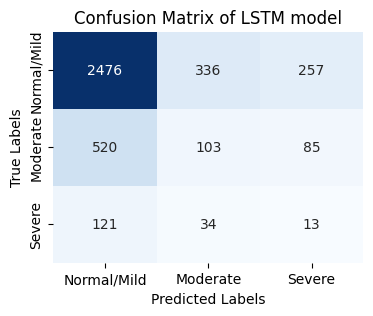

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Generate a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display all metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
    
labels = ['Normal/Mild', 'Moderate','Severe']
# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix[1:, 1:], annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of LSTM model')
plt.show()

## Transformer

In [18]:
backbone = timm.create_model('resnet50', pretrained=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Initialize Model3_ViT
model_ViT = Model3_ViT(backbone=backbone)

# Load model state dict from the checkpoint
Transformer_checkpoint = torch.load("/kaggle/input/transformerv2_bin/pytorch/default/1/pytorch_model_Transformer.bin")
model_ViT.load_state_dict(Transformer_checkpoint)

model_ViT = model_ViT.to(device)
model_ViT.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    print("start!")
    for i, batch in enumerate(valid_loader):
        print(i)
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        _, outputs = model_ViT(**inputs)
        preds = torch.argmax(outputs, dim=2).cpu().numpy()  

        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())
        
accuracy = accuracy_score(all_labels, all_preds)
print(f"test Accuracy: {accuracy:.4f}")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_23/1101210491.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless t

start!
0
1
2
3
4
5
6
7
8
9
10
11
12
test Accuracy: 0.7605


Accuracy: 0.7605
Precision: 0.6760
Recall: 0.7605
F1 Score: 0.7048


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


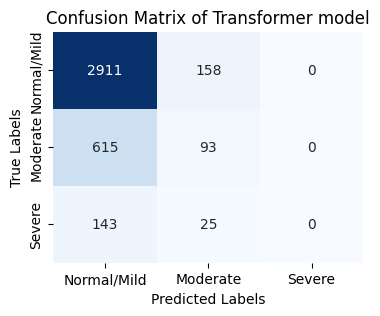

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Generate a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display all metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
    
labels = ['Normal/Mild', 'Moderate','Severe']
# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix[1:, 1:], annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Transformer model')
plt.show()

# ensemble

In [20]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config.model.name = 'efficientnet_b3.ra2_in1k'
backbone_LSTM = timm.create_model(config.model.name, pretrained=True)
model_LSTM = Model2_LSTM(backbone_LSTM)
model_LSTM.load_state_dict(torch.load("/kaggle/input/lstm/pytorch/default/1/best_model_LSTM_fold_0.pt", map_location=torch.device('cuda'), weights_only=False))
model_LSTM.to(device)
model_LSTM.eval()

backbone_ViT = timm.create_model('resnet50', pretrained=True)
model_ViT = Model3_ViT(backbone=backbone)
Transformer_checkpoint = torch.load("/kaggle/input/transformerv2_bin/pytorch/default/1/pytorch_model_Transformer.bin")
model_ViT.load_state_dict(Transformer_checkpoint)
model_ViT = model_ViT.to(device)
model_ViT.eval()
# valid_loader, valid_gt_submission = get_validation_data(train_df[train_df.fold == 0], train_series_descriptions_df, config)
all_preds = []
all_labels = []

with torch.no_grad():
    print("start!")
    for i, batch in enumerate(valid_loader):
        print(f"running on batch {i}")
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        
        _, outputs_LSTM = model_LSTM(**inputs)
        _, outputs_ViT = model_ViT(**inputs)
        outputs = (outputs_LSTM + outputs_ViT) / 2
        
        preds = torch.argmax(outputs, dim=2).cpu().numpy()  

        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())
        
accuracy = accuracy_score(all_labels, all_preds)
print(f"test Accuracy: {accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_23/3433605809.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless t

start!
running on batch 0
running on batch 1
running on batch 2
running on batch 3
running on batch 4
running on batch 5
running on batch 6
running on batch 7
running on batch 8
running on batch 9
running on batch 10
running on batch 11
running on batch 12
test Accuracy: 0.7608


Accuracy: 0.7608
Precision: 0.6720
Recall: 0.7608
F1 Score: 0.7017


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


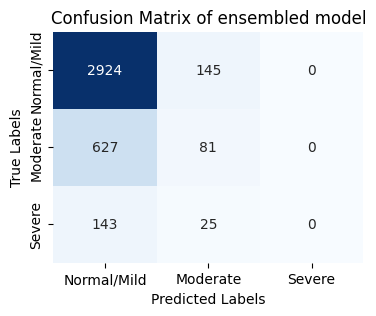

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Generate a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display all metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
    
labels = ['Normal/Mild', 'Moderate','Severe']
# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix[1:, 1:], annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of ensembled model')
plt.show()